In [1]:
import sys
sys.path.append('/home/cowvin/Documents/tcc_realestate')

import matplotlib.pyplot as plt
import re
import pandas as pd
import seaborn as sns
import pandas.api.types as ptypes
import numpy as np
import optuna
import joblib
from app.api.step import *
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score
from sklearn import ensemble
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, KFold

In [2]:
df_alg = pd.read_csv("../data/joao-pessoa-aluguel.csv")
df1 = pd.read_csv("../data/joao_pessoa.csv").drop(columns=["andar"])
df2 = pd.read_csv("../data/joao_pessoa1.csv") \
    .drop(columns=["z_lat", "z_lon", "bairro_completo",
                   "comercio", "bairro", "zona"]) \
    .transform(lambda x: x.apply(lambda y: float(y)) if ptypes.is_bool_dtype(x) else x)

In [3]:
df3 = pd \
    .read_csv('../data/aluguel_social_jp.csv', delimiter=';') \
    .query('`ANO DO PAGAMENTO` == 2023') \
    .dropna(subset=['BAIRRO']) \
    .rename(columns={'BAIRRO': 'bairro'}) \
    .assign(bairro=lambda x: x.bairro.str.strip().str.title()) \
    .replace(
        {
            r'M[AaNnGg]([a-zA-Z])*\sI': 'Mangabeira I',
            r'M[AaNnGg]([a-zA-Z])*\sII': 'Mangabeira II',
            r'M[AaNnGg]([a-zA-Z])*\sIII': 'Mangabeira III',
            r'M[AaNnGg]([a-zA-Z])*\sIV': 'Mangabeira IV',
            r'M[AaNnGg]([a-zA-Z])*\sVii': 'Mangabeira IV',
            'Mangabeira Iv': 'Mangabeira IV',
            'Mangabeira Iii': 'Mangabeira III',
            'Mangabeira Ii': 'Mangabeira II',
            'Mangabeira Vi': 'Mangabeira VI',
            'Mangabeira Vii': 'Mangabeira VII',
            'Mangabeira Viii': 'Mangabeira VIII',
            'Mangabeira, Viii': 'Mangabeira VIII',
            'Mangabeira 8': 'Mangabeira VIII',
            r'M[AaNnGg]([a-zA-Z])*': 'Mangabeira',
            r'Varad([a-zA-Z]).*': 'Varadouro',
            'Jd Veneza': 'Jardim Veneza',
            'Jd Cidade Universitaria': 'Jardim Cidade Universitaria',
            'Mangabeira \( Aratu\)': 'Mangabeira',
            'Monsenhor Mangabeira': 'Mangabeira',
            'Mangabeira 1': 'Mangabeira',
            'Mangabeira \(Aratu\)': 'Mangabeira',
            'Bairro Dos Estados': 'Estados',
            'Mangabeira 6': 'Mangabeira VI',
            'Cristo': 'Cristo Redentor',
        },
        regex=True
    ) \
    .replace(
        {
            'Monsenhor Mangabeira': 'Mangabeira',
            'Baixo Roger': 'Roger',
            'Funcionarios 2': 'Funcionarios II a IV',
            'Cristo Redentor Redentor': 'Cristo Redentor',
            'Baixo Roger ( Vila Lula\nLucena)': 'Roger',
            'Collinas Do Sul': 'Colinas do Sul',
            'Cidade Verde - Bairro Das Industrias': 'Bairro das Industrias',
            'Cristo Redentor/Vale Das Palmeiras': 'Cristo Redentor',
            'Biarro Das Industria': 'Bairro das Industrias',
            'Altiplano 2': 'Altiplano',
            'Dos Ipes': 'Bairro Dos Ipes',
            'Aeroclube/Bessa': 'Aeroclube',
            'Bairro Sao Jose': 'Sao Jose',
            'B. Industrias': 'Bairro das Industrias',
            'Industrias': 'Bairro das Industrias',
            'B Das Industrias': 'Bairro das Industrias',
            'Funcionarios Ii': 'Funcionarios II a IV',
            'Bela Vista/Cristo Redentor': 'Cristo Redentor',
            'Sao Jose/ Barreira': 'Sao Jose',
            'B. Dos Estados': 'Estados',
            '13 De Mangabeira': 'Mangabeira',
            'Cristro Redentor': 'Cristo Redentor',
            'Funcionario Iii': 'Funcionarios II a IV',
            'Gervasio Mangabeira': 'Mangabeira',
            'Ipes': 'Bairro Dos Ipes',
            'B. Das Industrias': 'Bairro das Industrias',
            'Joao Paulo Ii': 'Joao Paulo II',
            'Padreze': 'Padre Ze',
            'Valentina I': 'Valentina',
            'B. Dos Novais': 'Bairro dos novais',
            'Novais': 'Bairro dos novais',
            'Treze De Mangabeira': 'Mangabeira',
            'Estados': 'Bairro dos estados'
        }
    ) \
    .reset_index(drop=True)
df3 = df3.replace({'Estados': 'bairro dos estados'})

df3 = df3.assign(bairro=lambda x: x.bairro.str.lower().str.replace(' ', '_')) \
    .groupby(['bairro'], as_index=False).size() \
    .rename(columns={'size': 'qnt_beneficio'})

In [4]:
def extract_location(address):
    pattern_joao_pessoa = re.compile(r'(.+),\s*João Pessoa$')
    match_joao_pessoa = pattern_joao_pessoa.search(address)

    if match_joao_pessoa:
        return match_joao_pessoa.group(1).strip()

    pattern_general = re.compile(r',\s*([^,]+)$')
    match_general = pattern_general.search(address)

    if match_general:
        return match_general.group(1).strip()

    return None

def clear_addr(x):
    pattern = re.compile(r'[-,\s]*(.*?)\s*,?\s*João Pessoa - PB')
    extracted_parts = [pattern.search(address).group(1) if pattern.search(address) else None for address in x]

    return [re.sub(r'^.* - ', '', address) for address in extracted_parts]

df1 = df1 \
    .assign(
        bairro=lambda x: clear_addr(x.endereco),
        error=lambda x: list(map(lambda y: ('Rua' in y) or (y == ''), x.bairro.tolist())),
    ) \
    .query('error == False') \
    .reset_index(drop=True) \
    .drop(columns=['error']) \
    .replace(
        {
            'Valentina Figueiredo': 'Valentina de Figueiredo',
            'Jardim Treze de Maio': 'Jardim 13 de Maio'
        }
    )

df2 = df2.assign(bairro=lambda x: [extract_location(address) for address in x.endereco])

df_alg = df_alg \
    .assign(bairro=lambda x: clear_addr(x.endereco)) \
    .replace({
        'Altiplano Cabo Branco': 'Altiplano',
        'ipes': 'Bairro dos Ipes',
        'Estados': 'Bairro dos estados',
        'Jardim Treze de Maio': 'Jardim 13 de Maio',
        'Ipês': 'Bairro dos Ipes'
    })

df_alg = df_alg \
    .assign(
        bairro=lambda x: x.bairro.str.normalize('NFKD') \
            .str.encode('ascii', errors='ignore') \
            .str.decode('utf-8') \
            .str.lower() \
            .str.replace(' ', '_')
    ) \
    .rename(
        columns={
            'area': 'area_aluguel',
            'valor': 'valor_aluguel',
            # 'vaga': 'vaga_aluguel',
            # 'quarto': 'quarto_aluguel',
            # 'banheiro': 'banheiro_aluguel'
            }
        ) \
    .groupby(['bairro'], as_index=False) \
    [['area_aluguel', 'valor_aluguel']] \
    .median()

In [5]:
df = pd.concat([df1, df2]) \
    .drop_duplicates('id') \
    .reset_index(drop=True) \
    .drop(columns=['id', 'url']) \
    .query('bairro != "Monsenhor Magno"') \
    .replace(
        {
            'Altiplano Cabo Branco': 'Altiplano',
            'Estados': 'Bairro dos estados',
            'Ipês': 'Bairro dos ipes',
            'Industrias': 'Bairro das Industrias',
            'Cidade dos Funcionarios II': 'Funcionários II a IV',
            'Cidade dos Colibris': 'Colibris',
            'Conjunto Pedro Gondim': 'Pedro gondim',
            'José Américo de Almeida': 'jose americo'
        }
    )

df = df \
    .assign(bairro=lambda x: x.bairro.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.replace(' ', '_').str.lower()) \
    .merge(df_alg, on='bairro', how='left') \
    .merge(df3, on='bairro', how='left')\
    .reset_index(drop=True)

## Cleaning

In [6]:
def remove_outliers_iqr(data, feature, threshold=1.5):
    df = data.copy()
    q1, q3 = np.percentile(df[feature],  [1, 99])
    iqr = q3 - q1
    upper_bound = q3 + threshold * iqr

    removed_rows = df[df[feature] > upper_bound].index

    if(feature == 'valor'):
        df = df.drop(removed_rows, axis=0)
        return df.query("valor >= 40000").reset_index(drop=True)
    else:
        return df.drop(removed_rows, axis=0).reset_index(drop=True)


In [7]:
df = df.fillna(
    value={
        "academia": 0, "area_servico": 0,
        "elevador": 0, "espaco_gourmet": 0,
        "piscina": 0, "playground": 0,
        "portaria_24_horas": 0, "quadra_de_esporte": 0,
        "salao_de_festa": 0, "sauna": 0,
        "spa": 0, "varanda_gourmet": 0}
    ) \
    .replace(["flat", "terrenos_lotes_condominio"],
             ["flats", "terrenos_lotes_e_condominios"]) \
    .assign(
        latitude_norm=lambda x: (x.latitude - x.latitude.mean()) / x.latitude.std(),
        longitude_norm=lambda x: (x.longitude - x.longitude.mean()) / x.longitude.std(),
    ) \
    .query("-2 < latitude_norm < 2") \
    .query("-2 < longitude_norm < 2") \
    .query("area < 150000 and area >= 20 and valor < 12_000_000 and valor > 40000") \
    .query("tipo not in ['casas_de_vila', 'sobrados', 'coberturas', 'casas_comerciais']") \
    .reset_index(drop=True) \
    .drop(columns=["longitude_norm", "latitude_norm"])

In [8]:
df = remove_outliers_iqr(
    df.assign(
        valor_area = df.valor * df.area
        ),
    "valor_area"
    ) \
    .drop(columns=["valor_area"])

## Train and test dataset

In [9]:
df['valor_cut'] = pd.cut(df['valor'],
    bins=[0.,2e5, 4e5, 6e5, 8e5, np.inf],
    labels=[1, 2, 3, 4, 5])

split = StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df.valor_cut):
    train_df = df.loc[train_index]
    test_df = df.loc[test_index]
train_df = train_df.drop(columns=['valor_cut']).reset_index(drop=True)
test_df = test_df.drop(columns=['valor_cut']).reset_index(drop=True)

# df.drop(columns=["valor_cut"]).to_csv("../../data/cleaned/jp_limpo.csv", index=False)
# train_df.to_csv("../../data/cleaned/train.csv", index=False)
# test_df.to_csv("../../data/cleaned/test.csv", index=False)

train_df = train_df.drop(columns=['qnt_beneficio'])
test_df = test_df.drop(columns=['qnt_beneficio'])

## Missing values

In [10]:
# g_missing = sns.displot(
#     data=train_df.isnull() \
#         .melt(value_name="Valores ausentes") \
#         .replace([False, True], ["Não é ausente", "Ausente"]) \
#         .groupby(["variable", "Valores ausentes"]).size() \
#         .reset_index(name="count") \
#         .assign(
#             proportion=lambda x: x.groupby("variable")["count"].transform(lambda y: y / y.sum())
#         ),
#     y="variable",
#     hue="Valores ausentes",
#     weights="proportion",
#     multiple="fill",
#     height=8,
#     aspect=1.1,
#     palette={"Não é ausente": "#f9a602", "Ausente": "gray"}
#     )

# sns.move_legend(obj=g_missing, loc="upper center",
#                 bbox_to_anchor=(.5, -.0001), ncol=2, title="")
# g_missing.set(xlabel="Proporção de valores ausentes (%)", ylabel="")

### Some functions

In [11]:
def display_scores(scores, confidence=0.95):

    print("Scores:", scores)
    print("Média:", scores.mean())
    print("Desvio Padrão:", scores.std())

In [12]:
def plot_error(scores):
    ax, fig = plt.subplots(figsize=(20, 20))
    lineplot = sns.lineplot(y=scores, x=list(range(1, 11)))
    plt.title('Raiz do erro quadrático médio', fontdict={'fontsize': 18})
    plt.xlabel('CV', fontdict={'fontsize': 14})
    plt.ylabel('RMSE', fontdict={'fontsize': 14})
    lineplot.set_xticklabels(lineplot.get_xticklabels(), fontdict={'fontsize': 13})
    lineplot.set_yticklabels(lineplot.get_yticklabels(), fontdict={'fontsize': 13})
    plt.show()

In [13]:
def plot_predict(model):
    plt.figure(figsize=(20, 20))
    scatter = sns.scatterplot(y=np.exp(model.predict(test_df.drop('valor', axis=1))), x=np.exp(test_df.valor) - 1)
    plt.title('Predições VS Valores Reais', fontdict={'fontsize': 18})
    plt.xlabel('Valores Reais', fontdict={'fontsize': 13})
    plt.ylabel('Predições', fontdict={'fontsize': 13})
    plt.show()

In [14]:
gbr_native = ensemble.GradientBoostingRegressor()
lgbm_native = LGBMRegressor(
    # **best_params_lgbm,
    random_state=42)
rf_native = ensemble.RandomForestRegressor()
xgboost_native = XGBRegressor()

## Modeling 

In [15]:
train_df = train_df.assign(valor=lambda x: np.log1p(x.valor))
test_df = test_df.assign(valor=lambda x: np.log1p(x.valor))

In [16]:
drop_cols_fit = ['endereco', 'bairro', 'iptu', 'condominio']

pipe_jp = Pipeline(
    [("imputer", Imputer()),
     ("new_feature", BedAreaBedToi()),
     ("onehot_encoder", OneEncoder()),
     ("yeo", YeoTransform()),
     ("log_transform", LogTransform()),
     ("scaling", Scale()),
    ])
pipe_jp.fit(train_df.drop(columns=drop_cols_fit))

Pipeline(steps=[('imputer', Imputer()), ('new_feature', BedAreaBedToi()),
                ('onehot_encoder', OneEncoder()), ('yeo', YeoTransform()),
                ('log_transform', LogTransform()), ('scaling', Scale())])

In [17]:
# df = df\
#     .assign(
#         id=lambda x: list(range(1, x.shape[0] + 1)),
#         bairro=lambda x: x
#         .bairro
#         .str
#         .replace('_', ' ')
#         .str.upper()
#         .replace(
#             {
#                 'ALTIPLANO': 'ALTIPLANO CABO BRANCO',
#                 'JOSE AMERICO': 'JOSÉ AMÉRICO',
#                 'TAMBAU': 'TAMBAÚ',
#                 'JARDIM CIDADE UNIVERSITARIA': 'JARDIM CIDADE UNIVERSITÁRIA',
#                 'MANAIRA': 'MANAÍRA',
#                 'VARJAO': 'VARJÃO',
#                 'BANCARIOS': 'BANCÁRIOS',
#                 'EXPEDICIONARIOS': 'EXPEDICIONÁRIOS',
#                 'JOAO AGRIPINO': 'JOÃO AGRIPINO',
#                 'MANDACARU': 'MANDACARÚ',
#                 'JARDIM SAO PAULO': 'JARDIM SÃO PAULO',
#                 'COLIBRIS': 'CIDADE DOS COLIBRIS',
#                 'ANATOLIA': 'ANATÓLIA',
#                 'MUCUMAGRO': 'MUÇUMAGRO',
#                 'AGUA FRIA': 'ÁGUA FRIA',
#                 'BAIRRO DOS IPES': 'BAIRRO DOS IPÊS',
#                 'JARDIM LUNA': 'BRISAMAR',
#                 'VALENTINA DE FIGUEIREDO': 'VALENTINA',
#                 'PLANALTO BOA ESPERANCA': 'PLANALTO DA BOA ESPERANÇA',
#                 'CUIA': 'CUIÁ',
#                 'MANGABEIRA IV': 'MANGABEIRA',
#                 'GEISEL': 'ERNESTO GEISEL',
#                 'JOAO PAULO II': 'JOÃO PAULO II',
#                 'TAMBIA': 'TAMBIÁ',
#                 'ALTO DO CEU': 'ALTO DO CÉU',
#                 'QUADRAMARES': 'PORTAL DO SOL',
#                 'CIDADE UNIVERSITARIA': 'JARDIM CIDADE UNIVERSITÁRIA',
#                 'MANGABEIRA VII': 'MANGABEIRA',
#                 'SAO JOSE': 'SÃO JOSÉ',
#                 'JARDIM 13 DE MAIO': 'TREZE DE MAIO',
#                 'PRAIA DO SOL': 'COSTA DO SOL',
#                 'SEIXAS': 'PONTA DO SEIXAS',
#                 'RANGEL': 'VARJÃO',
#                 'COLINAS DO SUL': 'GRAMAME',
#                 'AREA RURAL DE JOAO PESSOA': 'GRAMAME'
#             }
#         ).str.strip()
#     )\
#     .query('bairro not in ["INTERMATES", "PRAIA DE INTERMARES"]')#\
#     # .to_csv("data/cleaned/jp_limpo_bairro_correto2.csv", index=False)

In [18]:
train_df_novo = pipe_jp.transform(train_df.drop(columns=drop_cols_fit))
test_df_novo = pipe_jp.transform(test_df.drop(columns=drop_cols_fit))

In [19]:
train_df_novo = train_df_novo
test_df_novo = test_df_novo

In [20]:
# s = setup(train_df_novo, target='valor')
# best = compare_models()

In [21]:
test_df_clone = test_df.copy()

# Testing with pycaret

In [22]:
# from pycaret.regression import *

# regression_setup = setup(
#     data=train_df_novo,
#     target='valor',
#     session_id=42,
#     train_size=0.8,
#     verbose=True
# )

# best_models = compare_models(n_select=5, sort='RMSE', fold=20)

## Optim

### LGBM

In [23]:
def objective_lgbm(trial):
    num_leaves = trial.suggest_int('num_leaves', 100, 600)
    max_depth = trial.suggest_int('max_depth', 100, 500)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, .01)
    n_estimators = trial.suggest_int('n_estimators', 100, 2000)

    model = LGBMRegressor(
        num_leaves=num_leaves,
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        random_state=42
    )
    model.fit(X=train_df_novo.drop('valor', axis=1), y=train_df_novo.valor)

    cv_scores = np.expm1(np.sqrt(-cross_val_score(
        estimator=model,
        X=train_df_novo.drop('valor', axis=1),
        y=train_df_novo.valor,
        scoring='neg_mean_squared_error',
        cv=KFold(n_splits=20))))

    return np.mean(cv_scores)

In [24]:
study_lgbm = optuna.create_study(direction="minimize")
# study_lgbm.optimize(objective_lgbm, n_trials=100, n_jobs=3, show_progress_bar=True)

[I 2025-05-07 23:43:39,136] A new study created in memory with name: no-name-383dcbb4-7061-491b-9de7-23d89d3cf114


In [25]:
load_study_lgbm = joblib.load("study_pkl/study_lgbm.pkl")

get_params_trials_lgbm = load_study_lgbm.trials_dataframe()\
    .drop(
        columns=[
            "datetime_start", "datetime_complete",
            "duration", "value", "number", "state"
        ]
    )\
    .rename(
        columns={
            "params_learning_rate": "learning_rate",
            "params_num_leaves": "num_leaves",
            "params_max_depth": "max_depth",
            "params_n_estimators": "n_estimators",
        }
    )\
    .to_dict("records")
    # .assign(max_features="sqrt")\

In [ ]:
def evaluate_params(params):
    model = LGBMRegressor(**params, random_state=42)
    model.fit(X=train_df_novo.drop('valor', axis=1), y=train_df_novo.valor)

    cv_scores = np.expm1(np.sqrt(-cross_val_score(
        estimator=model,
        X=train_df_novo.drop('valor', axis=1),
        y=train_df_novo.valor,
        scoring='neg_mean_squared_error',
        cv=KFold(n_splits=20)
    )))

    return np.mean(cv_scores)

objective_value_lgbm = [evaluate_params(param) for param in get_params_trials_lgbm]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2262
[LightGBM] [Info] Number of data points in the train set: 25424, number of used features: 30
[LightGBM] [Info] Start training from score 13.051175


In [ ]:
creating_trials = [
    optuna.trial.create_trial(
        params=i[0],
        distributions={
            'n_estimators': optuna.distributions.IntDistribution(100, 2000),
            'num_leaves': optuna.distributions.IntDistribution(100, 500),
            'learning_rate': optuna.distributions.FloatDistribution(1e-4, 0.01),
            'max_depth': optuna.distributions.IntDistribution(100, 500),
        },
        value=i[1]
    )
    for i in zip(get_params_trials_lgbm, objective_value_lgbm)
]

for j in enumerate(creating_trials):
    j[1].number = j[0]

In [ ]:
study_lgbm.add_trials(
    creating_trials
)

In [ ]:
# joblib.dump(study_lgbm, "study_pkl/study_lgbm_new_var2.pkl")

In [25]:
best_params_lgbm_novas_variaveis = {
    'num_leaves': 202,
    'max_depth': 379,
    'learning_rate': 0.009857215099413444,
    'n_estimators': 1988}

best_params_lgbm = {
    'num_leaves': 247,
    'max_depth': 299,
    'learning_rate': 0.009035568789398086,
    'n_estimators': 1798}

In [26]:
lgbm = LGBMRegressor(
    **best_params_lgbm_novas_variaveis,
    random_state=42,
    n_jobs=1)

In [47]:
lgbm.fit(X=train_df_novo.drop(columns=['valor']), y=train_df_novo.valor)
lgbm.score(X=test_df_novo.drop(columns=['valor']), y=test_df_novo.valor)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2262
[LightGBM] [Info] Number of data points in the train set: 25424, number of used features: 30
[LightGBM] [Info] Start training from score 13.051175


0.8725794650754604

In [48]:
preds_lgbm = lgbm.predict(X=test_df_novo.drop(columns=['valor']))
test_df_clone['preds_lgbm'] = preds_lgbm

In [28]:
# print(
#     mean_absolute_percentage_error(
#         test_df_clone.valor,
#         preds_lgbm
#     )
# )
# print(
#         np.expm1(root_mean_squared_error(
#             test_df_clone.valor,
#             preds_lgbm
#         ))
#     )

# print(
#         r2_score(
#             test_df_clone.valor,
#             preds_lgbm
#         )
#     )

print(
    mean_absolute_percentage_error(
        np.expm1(test_df_clone.valor),
        np.expm1(preds_lgbm)
    )
)
print(
        root_mean_squared_error(
            np.expm1(test_df_clone.valor),
            np.expm1(preds_lgbm)
        )
    )

print(
        r2_score(
            np.expm1(test_df_clone.valor),
            np.expm1(preds_lgbm)
        )
    )

0.1834192098928516
228784.36968510042
0.8528155127634484


In [49]:
print(np.round(228784.36968510042, 2))
print(np.round(0.8528155127634484 * 100, 2))
print(np.round(0.1834192098928516 * 100, 2))

228784.37
85.28
18.34


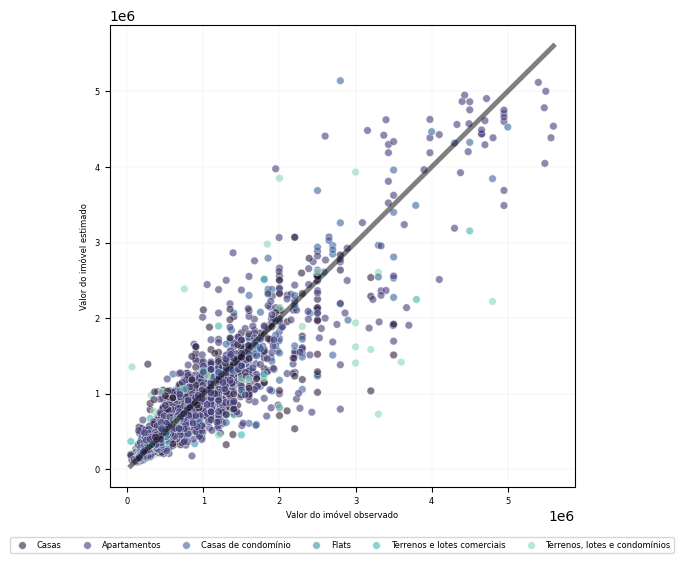

In [50]:
fig, ax = plt.subplots(figsize=(6, 6))

plot = sns.scatterplot(
    data=test_df_clone\
        .assign(
            valor=lambda x: np.expm1(x.valor),
            preds_lgbm=lambda x: np.expm1(x.preds_lgbm),
        ),
    x='valor',
    y='preds_lgbm',
    s=30,
    hue='tipo',
    palette='mako',
    alpha=.6)

min_val = min(np.expm1(test_df_clone['valor'].min()), np.expm1(test_df_clone['preds_lgbm'].min()))
max_val = max(np.expm1(test_df_clone['valor'].max()), np.expm1(test_df_clone['preds_lgbm'].max()))
plot.plot(
    [min_val, max_val],
    [min_val, max_val],
    color="black",
    linewidth=3.5,
    alpha=.5
    )

plot.grid(True, color='grey', linewidth=.05)
plot.set_facecolor('white')
plot.spines['top'].set_visible(True)
plot.spines['right'].set_visible(True)
plot.spines['left'].set_visible(True)
plot.spines['bottom'].set_visible(True)

plot.set_xlabel('Valor do imóvel observado', fontsize=6)
plot.set_ylabel('Valor do imóvel estimado', fontsize=6)
plot.tick_params("both", labelsize=6)

l = plt.legend(loc="upper center", bbox_to_anchor=(.5, -.1), ncol=7, prop={"size": 6})
l.get_texts()[0].set_text('Casas')
l.get_texts()[1].set_text('Apartamentos')
l.get_texts()[2].set_text('Casas de condomínio')
l.get_texts()[3].set_text('Flats')
l.get_texts()[4].set_text('Terrenos e lotes comerciais')
l.get_texts()[5].set_text('Terrenos, lotes e condomínios')
plt.savefig("includes/lgbm_plot_predict_no_transform.svg", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
#joblib.dump(study_lgbm, 'study_pkl/study_lgbm.pkl')

### Random Forest

In [51]:
forest = ensemble.RandomForestRegressor(
    n_estimators=653,
    max_depth=21,
    # **study.best_params,
    random_state=42,
    max_features="sqrt",
    n_jobs=1)

In [52]:
forest.fit(X=train_df_novo.drop(columns=['valor']), y=train_df_novo.valor)

RandomForestRegressor(max_depth=21, max_features='sqrt', n_estimators=653,
                      n_jobs=1, random_state=42)

In [59]:
forest.score(X=test_df_novo.drop(columns=['valor']), y=test_df_novo.valor)

0.8710419870429855

In [53]:
preds = forest.predict(X=test_df_novo.drop(columns=['valor']))
test_df_clone['preds'] = preds

In [43]:
# print(mean_absolute_percentage_error(test_df_clone.valor, preds))
# print(np.expm1(root_mean_squared_error(test_df_clone.valor, preds)))


print(
    mean_absolute_percentage_error(
        np.expm1(test_df_clone.valor),
        np.expm1(preds)
    )
)
print(
        root_mean_squared_error(
            np.expm1(test_df_clone.valor),
            np.expm1(preds)
        )
    )

print(
        r2_score(
            np.expm1(test_df_clone.valor),
            np.expm1(preds)
        )
    )

0.18320645216710893
234471.51292449297
0.8454071123437299


In [48]:
print(np.round(0.18320645216710893 * 100, 2))
print(np.round(234471.51292449297, 2))
print(np.round(0.8454071123437299 * 100, 2))

18.32
234471.51
84.54


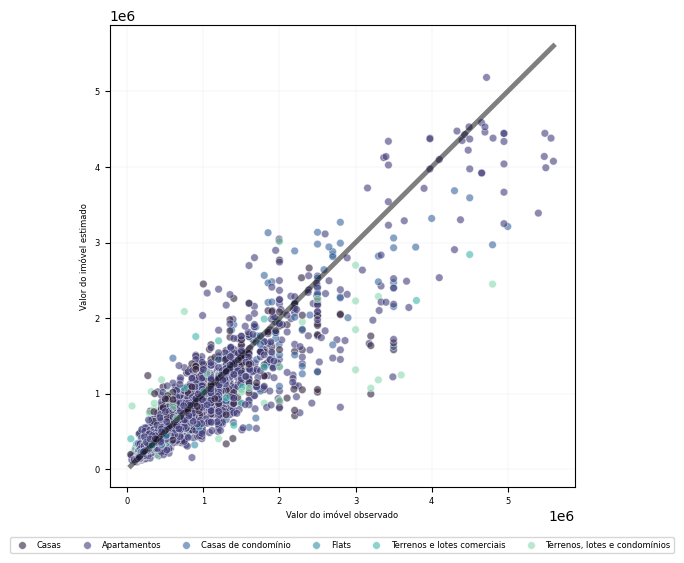

In [59]:
fig, ax = plt.subplots(figsize=(6, 6))
# fig = plt.Figure(figsize=(5.7, 2.7))

plot = sns.scatterplot(
    data=test_df_clone\
        .assign(
            valor=lambda x: np.expm1(x.valor),
            preds=lambda x: np.expm1(x.preds)
        ),
    x='valor',
    y='preds',
    s=30,
    hue='tipo',
    palette='mako',
    alpha=.6)

min_val = min(np.expm1(test_df_clone['valor'].min()), np.expm1(test_df_clone['preds'].min()))
max_val = max(np.expm1(test_df_clone['valor'].max()), np.expm1(test_df_clone['preds'].max()))
plot.plot(
    [min_val, max_val],
    [min_val, max_val],
    color="black",
    linewidth=3.5,
    alpha=.5
    )

plot.grid(True, color='grey', linewidth=.05)
plot.set_facecolor('white')
plot.spines['top'].set_visible(True)
plot.spines['right'].set_visible(True)
plot.spines['left'].set_visible(True)
plot.spines['bottom'].set_visible(True)

plot.set_xlabel('Valor do imóvel observado', fontsize=6)
plot.set_ylabel('Valor do imóvel estimado', fontsize=6)
plot.tick_params(axis="both", labelsize=6)

l = plt.legend(loc="upper center", bbox_to_anchor=(.5, -.10), ncol=7, prop={"size": 6})
l.get_texts()[0].set_text('Casas')
l.get_texts()[1].set_text('Apartamentos')
l.get_texts()[2].set_text('Casas de condomínio')
l.get_texts()[3].set_text('Flats')
l.get_texts()[4].set_text('Terrenos e lotes comerciais')
l.get_texts()[5].set_text('Terrenos, lotes e condomínios')
plt.savefig("includes/rf_plot_predict_no_transform.svg", dpi=600, bbox_inches='tight')
plt.show()

In [21]:
def objective_rf(trial):
    params = dict(
        n_estimators=trial.suggest_int(name='n_estimators', low=1, high=1000),
        max_depth=trial.suggest_int(name='max_depth', low=20, high=1000),
        max_features='sqrt',
        random_state=42
    )

    model = ensemble.RandomForestRegressor(
        **params
    )
    model.fit(X=train_df_novo.drop('valor', axis=1), y=train_df_novo.valor)

    cv_scores = np.expm1(np.sqrt(-cross_val_score(
        estimator=model,
        X=train_df_novo.drop("valor", axis=1),
        y=train_df_novo.valor,
        scoring="neg_mean_squared_error",
        cv=KFold(n_splits=20))))

    return np.mean(cv_scores)

In [52]:
study = optuna.create_study(direction="minimize")
# study.optimize(objective_rf, n_trials=100, show_progress_bar=True, n_jobs=3)

[I 2025-03-16 12:49:13,430] A new study created in memory with name: no-name-6b017150-1294-472d-a7f2-06d3d45ade61


In [53]:
load_study_rf = joblib.load("study_pkl/study_rf.pkl")

get_params_trials_rf = load_study_rf.trials_dataframe()\
    .drop(
        columns=[
            "datetime_start", "datetime_complete",
            "duration", "value", "number", "state"
        ]
    )\
    .rename(
        columns={
            "params_max_depth": "max_depth",
            "params_n_estimators": "n_estimators",
        }
    )\
    .to_dict("records")
    # .assign(max_features="sqrt")\

In [ ]:
def evaluate_params(params):
    model = ensemble.RandomForestRegressor(**params, max_features="sqrt", random_state=42)
    model.fit(X=train_df_novo.drop('valor', axis=1), y=train_df_novo.valor)

    cv_scores = np.expm1(np.sqrt(-cross_val_score(
        estimator=model,
        X=train_df_novo.drop('valor', axis=1),
        y=train_df_novo.valor,
        scoring='neg_mean_squared_error',
        cv=KFold(n_splits=20)
    )))

    return np.mean(cv_scores)

objective_value_rf = [evaluate_params(param) for param in get_params_trials_rf]

In [54]:
creating_trials = [
    optuna.trial.create_trial(
        params=i[0],
        distributions={
            'n_estimators': optuna.distributions.IntDistribution(1, 1000),
            'max_depth': optuna.distributions.IntDistribution(20, 1000),
        },
        value=i[1]
    )
    for i in zip(get_params_trials_rf, objective_value_rf)
]

for j in enumerate(creating_trials):
    j[1].number = j[0]

In [56]:
study.add_trials(creating_trials)

In [ ]:
# joblib.dump(study, 'study_pkl/study_rf_new_var.pkl')

FrozenTrial(number=62, state=TrialState.COMPLETE, values=[0.2908411040056861], datetime_start=datetime.datetime(2025, 3, 16, 12, 49, 18, 676318), datetime_complete=datetime.datetime(2025, 3, 16, 12, 49, 18, 676318), params={'max_depth': 21, 'n_estimators': 653}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=1, step=1), 'max_depth': IntDistribution(high=1000, log=False, low=20, step=1)}, trial_id=62, value=None)

In [ ]:
plot = optuna.visualization.plot_param_importances(study)
plot.update_layout(
    title="",
    xaxis_title="Importância dos Hiperparâmetros",
    yaxis_title="Hiperparâmetros"
)

## Gradient boosting

In [30]:
def objective_gbr(trial):
    learning_rate = trial.suggest_float(name='learning_rate', low=0.1e-5, high=0.1)
    n_estimators = trial.suggest_int(name='n_estimators', low=50, high=1500)
    max_depth = trial.suggest_int(name='max_depth', low=3, high=500)
    max_features = 'sqrt'


    model = ensemble.GradientBoostingRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42,
        max_features=max_features,
    )
    model.fit(X=train_df_novo.drop('valor', axis=1), y=train_df_novo.valor)

    cv_scores = np.expm1(np.sqrt(-cross_val_score(
        estimator=model,
        X=train_df_novo.drop('valor', axis=1),
        y=train_df_novo.valor,
        scoring='neg_mean_squared_error',
        cv=KFold(n_splits=20))))

    return np.mean(cv_scores)


In [ ]:
# study_gdr = optuna.create_study(direction='minimize')
# study_gdr.optimize(objective_gbr, n_trials=100, show_progress_bar=True)

[I 2025-03-14 18:44:28,872] A new study created in memory with name: no-name-df571c3c-54a7-41ce-aa55-55ae6c110873


In [77]:
load_study_gdr = joblib.load("study_pkl/study_gdt.pkl")

get_params_trials_gdr = load_study_gdr.trials_dataframe()\
    .drop(
        columns=[
            "datetime_start", "datetime_complete",
            "duration", "value", "number", "state"
        ]
    )\
    .rename(
        columns={
            "params_learning_rate": "learning_rate",
            "params_max_depth": "max_depth",
            "params_n_estimators": "n_estimators",
        }
    )\
    .to_dict("records")
    # .assign(max_features="sqrt")\

In [58]:
def evaluate_params(params):
    model = ensemble.GradientBoostingRegressor(**params, max_features="sqrt", random_state=42)
    model.fit(X=train_df_novo.drop('valor', axis=1), y=train_df_novo.valor)

    cv_scores = np.expm1(np.sqrt(-cross_val_score(
        estimator=model,
        X=train_df_novo.drop('valor', axis=1),
        y=train_df_novo.valor,
        scoring='neg_mean_squared_error',
        cv=KFold(n_splits=20)
    )))

    return np.mean(cv_scores)

objective_value_gdr = [evaluate_params(param) for param in get_params_trials_gdr]

In [78]:
creating_trials = [
    optuna.trial.create_trial(
        params=i[0],
        distributions={
            'n_estimators': optuna.distributions.IntDistribution(50, 1500),
            'learning_rate': optuna.distributions.FloatDistribution(1e-5, 0.1),
            'max_depth': optuna.distributions.IntDistribution(3, 500),
        },
        value=i[1]
    )
    for i in zip(get_params_trials_gdr, objective_value_gdr)
]

for j in enumerate(creating_trials):
    j[1].number = j[0]

In [ ]:
# study_gdr.add_trials(
#     creating_trials
# )

In [55]:
best_params_gdt_novas_variaveis = {
    'learning_rate': 0.12142538710171984,
    'n_estimators': 570,
    'max_depth': 10
    }

best_params_gdt_novas_variaveis2 = {
    'learning_rate': 0.09806379927882525,
    'max_depth': 7,
    'n_estimators': 1404
    }

best_params_gdt = {
    'learning_rate': 0.08730488291054857,
    'n_estimators': 1500,
    'max_depth': 6
    }

gdt = ensemble.GradientBoostingRegressor(
    **best_params_gdt_novas_variaveis2,
    random_state=42,
    max_features="sqrt")

In [56]:
gdt.fit(X=train_df_novo.drop(columns=['valor']), y=train_df_novo.valor)
gdt.score(X=test_df_novo.drop(columns=['valor']), y=test_df_novo.valor)

0.8732712851591108

In [57]:
preds_gdt = gdt.predict(X=test_df_novo.drop(columns=['valor']))
test_df_clone['preds_gdt'] = preds_gdt

In [61]:
# print(mean_absolute_percentage_error(test_df_clone.valor, preds_gdt))
# print(np.expm1(root_mean_squared_error(test_df_clone.valor, preds_gdt)))


print(
    mean_absolute_percentage_error(
        np.expm1(test_df_clone.valor),
        np.expm1(preds_gdt)
    )
)
print(
        root_mean_squared_error(
            np.expm1(test_df_clone.valor),
            np.expm1(preds_gdt)
        )
    )

print(
        r2_score(
            np.expm1(test_df_clone.valor),
            np.expm1(preds_gdt)
        )
    )

0.18205702339215646
227677.44444829412
0.8542363099192278


In [64]:
print(np.round(0.18205702339215646 * 100, 2))
print(np.round(227677.44444829412, 2))
print(np.round(0.8542363099192278 * 100, 2))

18.21
227677.44
85.42


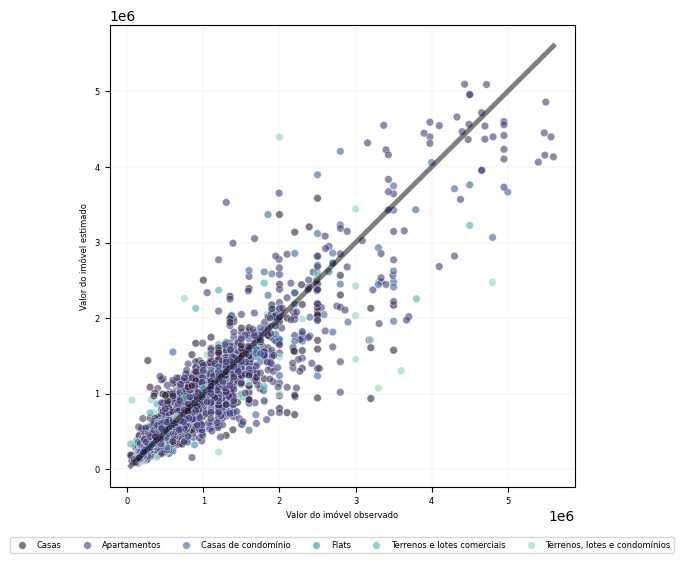

In [60]:
fig, ax = plt.subplots(figsize=(6, 6))

plot = sns.scatterplot(
    data=test_df_clone\
        .assign(
            valor=lambda x: np.expm1(x.valor),
            preds_gdt=lambda x: np.expm1(x.preds_gdt)
        ),
    x='valor',
    y='preds_gdt',
    s=30,
    hue='tipo',
    palette='mako',
    alpha=.6)

min_val = min(np.expm1(test_df_clone['valor'].min()), np.expm1(test_df_clone['preds_gdt'].min()))
max_val = max(np.expm1(test_df_clone['valor'].max()), np.expm1(test_df_clone['preds_gdt'].max()))
plot.plot(
    [min_val, max_val],
    [min_val, max_val],
    color="black",
    linewidth=3.5,
    alpha=.5
    )

plot.grid(True, color='grey', linewidth=.05)
plot.set_facecolor('white')
plot.spines['top'].set_visible(True)
plot.spines['right'].set_visible(True)
plot.spines['left'].set_visible(True)
plot.spines['bottom'].set_visible(True)

plot.set_xlabel('Valor do imóvel observado', fontsize=6)
plot.set_ylabel('Valor do imóvel estimado', fontsize=6)
plot.tick_params(axis="both", labelsize=6)

l = plt.legend(loc="upper center", bbox_to_anchor=(.5, -.1), ncol=7, prop={"size": 6})
l.get_texts()[0].set_text('Casas')
l.get_texts()[1].set_text('Apartamentos')
l.get_texts()[2].set_text('Casas de condomínio')
l.get_texts()[3].set_text('Flats')
l.get_texts()[4].set_text('Terrenos e lotes comerciais')
l.get_texts()[5].set_text('Terrenos, lotes e condomínios')
plt.savefig("includes/gdt_plot_predict_no_transform.svg", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
# joblib.dump(study_gdr, "study_pkl/study_gdt.pkl")

### XGBoost

In [65]:
def objective_xgboost(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-7, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 50),
        'random_state': 42
    }

    model = XGBRegressor(**params)
    model.fit(X=train_df_novo.drop('valor', axis=1), y=train_df_novo.valor)

    cv_scores = np.expm1(np.sqrt(-cross_val_score(
        estimator=model,
        X=train_df_novo.drop('valor', axis=1),
        y=train_df_novo.valor,
        scoring='neg_mean_squared_error',
        cv=KFold(n_splits=20))))

    return np.mean(cv_scores)


In [33]:
best_params_xgb_novas_variaveis = {
    'n_estimators': 605,
    'learning_rate': 0.07738897474596959,
    'max_depth': 7}

best_params_xgb = {
    'n_estimators': 788,
    'learning_rate': 0.07119699155402735,
    'max_depth': 8}

xgb = XGBRegressor(
    **best_params_xgb,
    random_state=42)

In [62]:
xgb.fit(X=train_df_novo.drop(columns=['valor']), y=train_df_novo.valor)
xgb.score(X=test_df_novo.drop(columns=['valor']), y=test_df_novo.valor)

0.8724599397713824

In [63]:
preds_xgb = xgb.predict(X=test_df_novo.drop(columns=['valor']))
test_df_clone['preds_xgb'] = preds_xgb

In [62]:
# print(mean_absolute_percentage_error(test_df_clone.valor, preds_xgb))
# print(np.expm1(root_mean_squared_error(test_df_clone.valor, preds_xgb)))

print(
    mean_absolute_percentage_error(
        np.expm1(test_df_clone.valor),
        np.expm1(preds_xgb)
    )
)
print(
        root_mean_squared_error(
            np.expm1(test_df_clone.valor),
            np.expm1(preds_xgb)
        )
    )

print(
        r2_score(
            np.expm1(test_df_clone.valor),
            np.expm1(preds_xgb)
        )
    )

0.18133695176106107
228300.82747847852
0.8534370124054966


In [72]:
print(np.round(0.18133695176106107 * 100, 2))
print(np.round(228300.82747847852, 2))
print(np.round(0.8534370124054966 * 100, 2))

18.13
228300.83
85.34


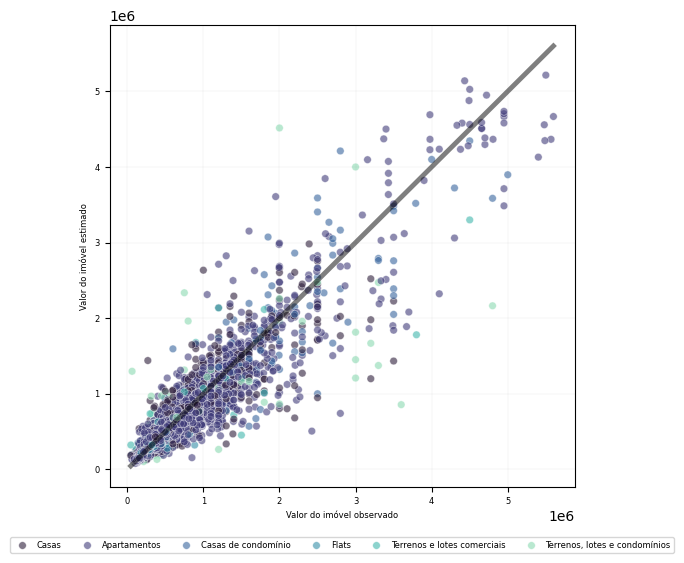

In [64]:
# fig, ax = plt.subplots(figsize=(13, 13))
fig, ax = plt.subplots(figsize=(6, 6))

plot = sns.scatterplot(
    data=test_df_clone\
        .assign(
            valor=lambda x: np.expm1(x.valor),
            preds_xgb=lambda x: np.expm1(x.preds_xgb)
        ),
    x='valor',
    y='preds_xgb',
    s=30,
    hue='tipo',
    palette='mako',
    alpha=.6)

min_val = min(np.expm1(test_df_clone['valor'].min()), np.expm1(test_df_clone['preds_xgb'].min()))
max_val = max(np.expm1(test_df_clone['valor'].max()), np.expm1(test_df_clone['preds_xgb'].max()))
plot.plot(
    [min_val, max_val],
    [min_val, max_val],
    color="black",
    linewidth=3.5,
    alpha=.5
    )

plot.grid(True, color='grey', linewidth=.05)
plot.set_facecolor('white')
plot.spines['top'].set_visible(True)
plot.spines['right'].set_visible(True)
plot.spines['left'].set_visible(True)
plot.spines['bottom'].set_visible(True)

plot.set_xlabel('Valor do imóvel observado', fontsize=6)
plot.set_ylabel('Valor do imóvel estimado', fontsize=6)
plot.tick_params(axis="both", labelsize=6)

l = plt.legend(loc="upper center", bbox_to_anchor=(.5, -.10), ncol=7, prop={"size": 6})
l.get_texts()[0].set_text('Casas')
l.get_texts()[1].set_text('Apartamentos')
l.get_texts()[2].set_text('Casas de condomínio')
l.get_texts()[3].set_text('Flats')
l.get_texts()[4].set_text('Terrenos e lotes comerciais')
l.get_texts()[5].set_text('Terrenos, lotes e condomínios')
plt.savefig("includes/xgb_plot_predict_no_transform.svg", dpi=600, bbox_inches='tight')
plt.show()

In [89]:
study_xgb = optuna.create_study(direction='minimize')
# study_xgb.optimize(objective_xgboost, n_trials=100, n_jobs=3)

[I 2025-03-12 00:13:20,817] A new study created in memory with name: no-name-45af9ca3-e712-4273-b14a-8c91415620ab


In [39]:
load_study_xgb = joblib.load("study_pkl/study_xgb.pkl")

In [57]:
get_params_trials_xgb = load_study_xgb.trials_dataframe()\
    .drop(
        columns=[
            "datetime_start", "datetime_complete",
            "duration", "value", "number", "state"
        ]
    )\
    .rename(
        columns={
            "params_learning_rate": "learning_rate",
            "params_max_depth": "max_depth",
            "params_n_estimators": "n_estimators",
        }
    )\
    .to_dict("records")

In [58]:
def evaluate_params(params):
    model = XGBRegressor(**params, random_state=42)
    model.fit(X=train_df_novo.drop('valor', axis=1), y=train_df_novo.valor)

    cv_scores = np.expm1(np.sqrt(-cross_val_score(
        estimator=model,
        X=train_df_novo.drop('valor', axis=1),
        y=train_df_novo.valor,
        scoring='neg_mean_squared_error',
        cv=KFold(n_splits=20)
    )))

    return np.mean(cv_scores)

objective_value_xgb = [evaluate_params(param) for param in get_params_trials_xgb]

In [73]:
creating_trials = [
    optuna.trial.create_trial(
        params=i[0],
        distributions={
            'n_estimators': optuna.distributions.IntDistribution(50, 1000),
            'learning_rate': optuna.distributions.FloatDistribution(1e-7, 0.5),
            'max_depth': optuna.distributions.IntDistribution(3, 50),
        },
        value=i[1]
    )
    for i in zip(get_params_trials_xgb, objective_value_xgb)
]

for j in enumerate(creating_trials):
    j[1].number = j[0]

In [ ]:
study_xgb.add_trials(
    creating_trials
)

In [ ]:
study_xgb.optimize(objective_xgboost, n_trials=99, n_jobs=3)

## Stacking

In [36]:
estimators = [
    ('xgb', XGBRegressor(**best_params_xgb, random_state=42)),
    ('rf', ensemble.RandomForestRegressor(
        # n_estimators=653,
        # max_depth=21,
        **joblib.load("study_pkl/study_rf_new_var.pkl").best_params,
        random_state=42,
        max_features="sqrt",
        n_jobs=1
    )),
    ('lgbm', LGBMRegressor(**best_params_lgbm_novas_variaveis, random_state=42)),
    ('gdt', ensemble.GradientBoostingRegressor(
        **best_params_gdt_novas_variaveis2,
        random_state=42,
        max_features="sqrt"
    ))
]

stacking = ensemble.StackingRegressor(
    estimators=estimators,
    final_estimator=ensemble.RandomForestRegressor(
        **joblib.load("study_pkl/study_rf_new_var.pkl").best_params,
        random_state=42,
        max_features="sqrt",
    ),
    verbose=2,
    n_jobs=3
)

In [37]:
stacking.fit(X=train_df_novo.drop(columns=['valor']), y=train_df_novo.valor)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2262
[LightGBM] [Info] Number of data points in the train set: 25424, number of used features: 30
[LightGBM] [Info] Start training from score 13.051175


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2244

[LightGBM] [Info] Total Bins 2236
[LightGBM] [Info] [LightGBM] [Info] Number of data points in the train set: 20339, number of used features: 30
Number of data points in the train set: 20339, number of used features: 30
[LightGBM] [Info] Start training from score 13.054060
[LightGBM] [Info] Start training from score 13.052644
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2231
[LightGBM] [Info] Number of data points in the train s

[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:   20.8s remaining:   13.8s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:   23.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:   38.3s remaining:   25.5s
[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:   30.4s remaining:   20.3s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:  1.0min finished
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:   57.6s finished


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 20339, number of used features: 30
[LightGBM] [Info] Start training from score 13.051755
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2243
[LightGBM] [Info] Number of data points in the train set: 20340, number of used features: 30
[LightGBM] [Info] Start training from score 13.047820


[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:  1.9min remaining:  1.3min
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:  2.6min finished


StackingRegressor(estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                               LGBMRegressor(learning_rate=0.009857215099413444,
                                             max_depth=379, n_estimators=1988,
                                             num_leaves=202, random_state=42)),
                              ('gdt',
                               GradientBoostingRegressor(learning_rate=0.09806379927882525,
                                                         max_depth=7,
                                                         max_features='sqrt',
                                                         n_estimators=1404,
                                                         random_state=42))],
                  final_estimator=RandomForestRegressor(max_depth=21,
                                                        max_features='sqrt',
                                                        n_estimators=653,
                                                        random_state=42),
                  n_jobs=3, verbose=2)

In [38]:
stacking.score(X=test_df_novo.drop(columns=['valor']), y=test_df_novo.valor)

0.8726007998847289

In [39]:
preds_stacking = stacking.predict(X=test_df_novo.drop(columns=['valor']))
test_df_clone['preds_stacking'] = preds_stacking

In [111]:
# print(mean_absolute_percentage_error(test_df_clone.valor, preds_stacking))
# print(np.expm1(root_mean_squared_error(test_df_clone.valor, preds_stacking)))


print(
    mean_absolute_percentage_error(
        np.expm1(test_df_clone.valor),
        np.expm1(preds_stacking)
    )
)
print(
        root_mean_squared_error(
            np.expm1(test_df_clone.valor),
            np.expm1(preds_stacking)
        )
    )

print(
        r2_score(
            np.expm1(test_df_clone.valor),
            np.expm1(preds_stacking)
        )
    )

0.18323023923432633
228377.10612557048
0.8533390583667896


In [84]:
print(np.round(0.18323023923432633*100, 2))
print(np.round(228377.10612557048, 2))
print(np.round(0.8533390583667896 * 100, 2))

18.32
228377.11
85.33


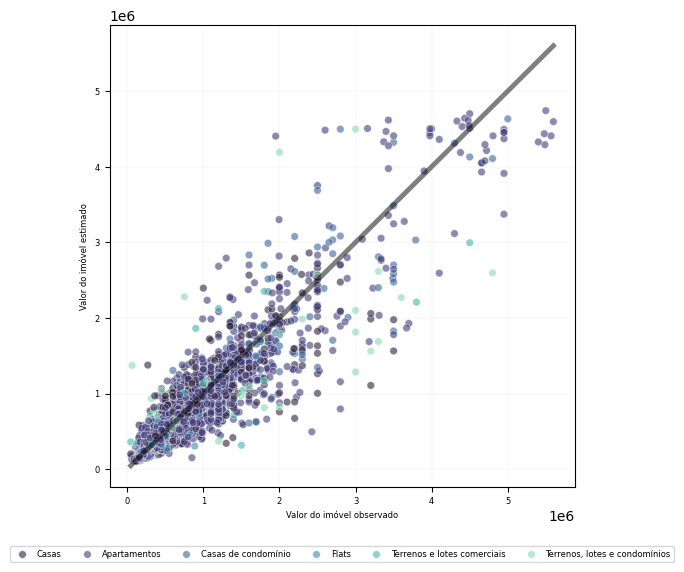

In [65]:
fig, ax = plt.subplots(figsize=(6, 6))

plot = sns.scatterplot(
    data=test_df_clone\
        .assign(
            valor=lambda x: np.expm1(x.valor),
            preds_stacking=lambda x: np.expm1(x.preds_stacking)
        ),
    x='valor',
    y='preds_stacking',
    s=30,
    hue='tipo',
    palette='mako',
    alpha=.6)

min_val = min(np.expm1(test_df_clone['valor'].min()), np.expm1(test_df_clone['preds_stacking'].min()))
max_val = max(np.expm1(test_df_clone['valor'].max()), np.expm1(test_df_clone['preds_stacking'].max()))
plot.plot(
    [min_val, max_val],
    [min_val, max_val],
    color="black",
    linewidth=3.5,
    alpha=.5
    )

plot.grid(True, color='grey', linewidth=.05)
plot.set_facecolor('white')
plot.spines['top'].set_visible(True)
plot.spines['right'].set_visible(True)
plot.spines['left'].set_visible(True)
plot.spines['bottom'].set_visible(True)

plot.set_xlabel('Valor do imóvel observado', fontsize=6)
plot.set_ylabel('Valor do imóvel estimado', fontsize=6)
plot.tick_params("both", labelsize=6)

l = plt.legend(loc="upper center", bbox_to_anchor=(.5, -.12), ncol=7, fontsize=6)
l.get_texts()[0].set_text('Casas')
l.get_texts()[1].set_text('Apartamentos')
l.get_texts()[2].set_text('Casas de condomínio')
l.get_texts()[3].set_text('Flats')
l.get_texts()[4].set_text('Terrenos e lotes comerciais')
l.get_texts()[5].set_text('Terrenos, lotes e condomínios')
plt.savefig("includes/stacking_plot_predict_no_transform.svg", dpi=600, bbox_inches='tight')
plt.show()

In [29]:
# from sklearn.inspection import partial_dependence

# X = test_df_novo.drop(columns=['valor'])
# features = X.columns.tolist()
# cat_features = [
#     'encoder__tipo_apartamentos', 'encoder__tipo_casas',
#     'encoder__tipo_casas_de_condominio', 'encoder__tipo_flats',
#     'encoder__tipo_terrenos_e_lotes_comerciais', 'encoder__tipo_terrenos_lotes_e_condominios',
#     'vertical_horizontal', 'varanda_gourmet', 'spa', 'sauna', 'salao_de_festa',
#     'portaria_24_horas', 'quadra_de_esporte', 'playground', 'piscina', 'espaco_gourmet',
#     'elevador', 'academia'
# ]
# num_features = np.array(features)[~X.columns.isin(cat_features)].tolist()

# pdp = partial_dependence(
#     stacking,
#     features=num_features,
#     # categorical_features=cat_features,
#     kind='both',
#     X=X)

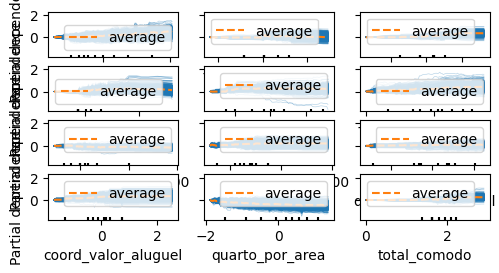

In [35]:
from sklearn.inspection import PartialDependenceDisplay

X = test_df_novo.drop(columns=['valor'])
features = X.columns.tolist()
cat_features = [
    'encoder__tipo_apartamentos', 'encoder__tipo_casas',
    'encoder__tipo_casas_de_condominio', 'encoder__tipo_flats',
    'encoder__tipo_terrenos_e_lotes_comerciais', 'encoder__tipo_terrenos_lotes_e_condominios',
    'vertical_horizontal', 'varanda_gourmet', 'spa', 'sauna', 'salao_de_festa',
    'portaria_24_horas', 'quadra_de_esporte', 'playground', 'piscina', 'espaco_gourmet',
    'elevador', 'academia', 'area_servico'
]
num_features = np.array(features)[~X.columns.isin(cat_features)].tolist()

ice_pdp = PartialDependenceDisplay\
    .from_estimator(
        # stacking,
        gdt,
        X,
        num_features,
        kind='both',
        centered=True,
        random_state=42
    )

fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(5.7, 2.7)

In [ ]:
from matplotlib.lines import Line2D

new_xlabels = ["Área", "Banheiro", "Quarto", "Vaga", "Latitude", "Longitude", "Área de aluguel", "Valor de aluguel"]


for idx, (ax1, xlabel) in enumerate(zip(ice_pdp.axes_.ravel(), new_xlabels)):
    if ax1 is not None:
        for line in ax1.get_lines()[:-1]:
            line.set_color('#00708d')
            line.set_alpha(0.4)

        pdp_line = ax1.get_lines()[-1]
        pdp_line.set_color('orange')
        pdp_line.set_linewidth(2.5)

        if ax1.get_legend() is not None:
            ax1.get_legend().remove()

        ax1.set_xlabel(xlabel, fontsize=13)

        if idx % 3 == 0:
            ax1.set_ylabel("Dependência parcial", fontsize=13)
        ax1.grid(True, which="major", axis="both", linestyle="-", color="lightgray", linewidth=0.8, alpha=0.9)
        ax1.grid(True, which="minor", axis="both", linestyle=":", color="lightgray", linewidth=0.5, alpha=0.8)

legend_line = Line2D([0], [0], color='orange', linestyle="--", linewidth=2.5, label="Média")
fig.legend(
    handles=[legend_line],
    loc="lower center",
    fontsize=13,
    ncol=1,
    bbox_to_anchor=(0.5, 0.02),
)

fig.tight_layout(rect=[0, 0.05, 1, 1])


In [48]:
# fig.savefig("../../tcc_escrita/includes/pdp_ice.svg", dpi=600, bbox_inches="tight")

In [43]:
import shap

X1000 = shap.utils.sample(train_df_novo.drop(columns="valor"), 1000)

explainer_stacking = shap.Explainer(gdt.predict, X1000)
shap_values_stacking = explainer_stacking(
    test_df_novo.drop(columns="valor")
)

PermutationExplainer explainer: 6358it [55:28,  1.91it/s]                           


In [ ]:
# shap_values = joblib.load('study_pkl/shap_values.pkl')

/tmp/ipykernel_237588/3508556074.py:22: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


Text(0.5, 2.722222222222216, 'Valor SHAP (impacto na predição do modelo)')

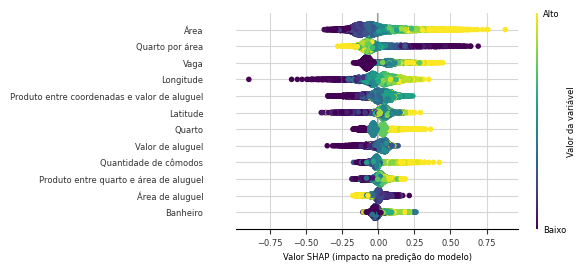

In [44]:
import matplotlib
import matplotlib.pyplot as plt

selected_cols = [
    "area", "banheiro", "quarto",
    "vaga", "latitude", "longitude",
    "area_aluguel", "valor_aluguel",
    "total_comodo", "coord_valor_aluguel",
    "quarto_area_aluguel", "quarto_por_area"
    ]

custom_cmap = matplotlib.colormaps["viridis"]

selected_indices = [i for i, col in enumerate(shap_values_stacking.feature_names) if col in selected_cols]

selected_features = test_df_novo.loc[:, test_df_novo.columns.isin(selected_cols)].columns.tolist()
filtered_df = test_df_novo[selected_features]

# filtered_shap_values = shap_values_stacking[:, [1, 3, 10, 14, 16, 17, 18, 19]]
filtered_shap_values = shap_values_stacking[:, selected_indices]

shap.summary_plot(
    filtered_shap_values,
    filtered_df,
    plot_type="dot",
    show=False,
    cmap=custom_cmap,
    plot_size=(6, 3)
)


feature_names = [
    "Banheiro", "Área de aluguel",
    "Produto entre quarto e área de aluguel",
    "Quantidade de cômodos", "Valor de aluguel",
    "Quarto", "Latitude", "Produto entre coordenadas e valor de aluguel",
    "Longitude", "Vaga", "Quarto por área", "Área"
]

# feature_names = [
#     "Área de aluguel", "Quarto", "Banheiro",
#     "Latitude", "Valor de aluguel",
#     "Longitude", "Vaga", "Área"
# ]

fig, ax = plt.gcf(), plt.gca()

ax.tick_params(axis="both", labelsize=6)
ax.set_yticklabels(feature_names, fontsize=6)
colorbar = fig.axes[-1]
colorbar.set_ylabel("Valor da variável", fontsize=6)
colorbar.set_yticklabels(["Baixo", "Alto"], fontsize=6)
ax.grid(True, which="major", axis="both", linestyle="-", color="lightgray", linewidth=0.8, alpha=0.9)
ax.grid(True, which="minor", axis="both", linestyle=":", color="lightgray", linewidth=0.5, alpha=0.8)

ax.set_axisbelow(True)

ax.set_xlabel("Valor SHAP (impacto na predição do modelo)", fontsize=6)

# plt.savefig("includes/shap_summary_plot2.svg", dpi=600, bbox_inches="tight")

/tmp/ipykernel_237588/3529705497.py:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


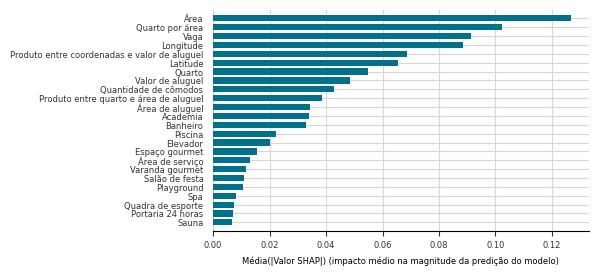

In [51]:
selected_cols = [
    "academia", "area", "area_servico",
    "banheiro", "elevador", "espaco_gourmet",
    "piscina", "playground", "portaria_24_horas",
    "quadra_de_esporte", "quarto", "salao_de_festa",
    "sauna", "spa", "vaga", "varanda_gourmet", "latitude", "longitude",
    "area_aluguel", "valor_aluguel", "total_comodo", "quarto_por_area",
    "quarto_area_aluguel", "coord_valor_aluguel"
    ]

selected_features = test_df_novo.loc[:, test_df_novo.columns.isin(selected_cols)].columns.tolist()
filtered_df = test_df_novo[selected_features]

selected_indices = [i for i, col in enumerate(shap_values_stacking.feature_names) if col in selected_cols]

filtered_shap_values = shap_values_stacking[:, selected_indices]

shap.summary_plot(
    filtered_shap_values,
    filtered_df,
    max_display=40,
    plot_type="bar",
    color="#00708d",
    show=False,
    plot_size=(6, 3))

fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel("Média(|Valor SHAP|) (impacto médio na magnitude da predição do modelo)", fontsize=6)

feature_names=[
    "Área", "Quarto por área", "Vaga", "Longitude",
    "Produto entre coordenadas e valor de aluguel", "Latitude",
    "Quarto", "Valor de aluguel", "Quantidade de cômodos",
    "Produto entre quarto e área de aluguel",
    "Área de aluguel", "Academia",
    "Banheiro", "Piscina", "Elevador",
    "Espaço gourmet", "Área de serviço",
    "Varanda gourmet", "Salão de festa",
    "Playground", "Spa", "Quadra de esporte",
    "Portaria 24 horas", "Sauna"
    ]
ax.tick_params(axis="both", labelsize=6)
ax.set_yticklabels(feature_names[::-1], fontsize=6)
ax.grid(True, which="major", axis="both", linestyle="-", color="lightgray", linewidth=0.8, alpha=0.9)
ax.grid(True, which="minor", axis="both", linestyle=":", color="lightgray", linewidth=0.5, alpha=0.8)

ax.set_axisbelow(True)

plt.savefig("includes/shap_importance2.svg", dpi=600, bbox_inches="tight")

In [110]:
def dep_plot(var, label):
    shap.dependence_plot(
        var,
        shap_values_stacking.values,
        test_df_novo.drop(columns="valor").values,
        feature_names=test_df_novo.drop(columns="valor").columns,
        alpha=.7,
        dot_size=50,
        show=False,
        color="#00708d",
        interaction_index=None,
        )
    fig, ax = plt.gcf(), plt.gca()
    fig.set_size_inches(10, 5)

    ax.set_xlabel(label, fontsize=13)
    ax.set_ylabel(f"Valores SHAP para\n{label}", fontsize=13)
    # ax.tick_params(axis="both", labelsize=6)
    ax.grid(True, which="major", axis="both", linestyle="-", color="lightgray", linewidth=0.8, alpha=0.9)
    ax.grid(True, which="minor", axis="both", linestyle=":", color="lightgray", linewidth=0.5, alpha=0.8)
    plt.savefig(f"includes/dependence_plot_cat/dep_plot_{var}2.svg", dpi=600, bbox_inches="tight")

In [97]:
train_df_novo.columns

Index(['academia', 'area', 'area_servico', 'banheiro', 'elevador',
       'espaco_gourmet', 'piscina', 'playground', 'portaria_24_horas',
       'quadra_de_esporte', 'quarto', 'salao_de_festa', 'sauna', 'spa', 'vaga',
       'valor', 'varanda_gourmet', 'latitude', 'longitude', 'area_aluguel',
       'valor_aluguel', 'quarto_area_aluguel', 'coord_valor_aluguel',
       'quarto_por_area', 'total_comodo', 'encoder__tipo_apartamentos',
       'encoder__tipo_casas', 'encoder__tipo_casas_de_condominio',
       'encoder__tipo_flats', 'encoder__tipo_terrenos_e_lotes_comerciais',
       'encoder__tipo_terrenos_lotes_e_condominios'],
      dtype='object')

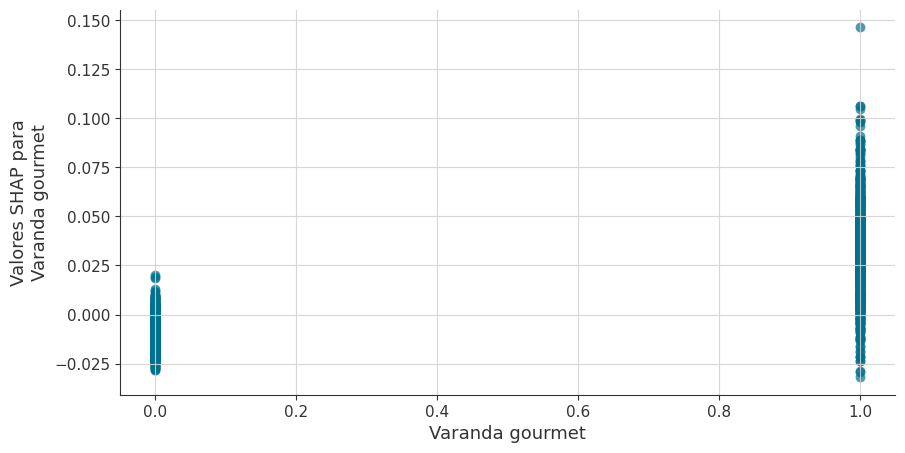

In [123]:
dep_plot("varanda_gourmet", "Varanda gourmet")